In [1]:
import gym

env = gym.make("MountainCar-v0")
env. reset()
for step in range(1000):
    env. render()
    action = env.action_space. sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated | truncated

    print(step, next_state, reward, terminated, truncated, info)
env. close()

0 [-0.5458348   0.00117544] -1.0 False False {}
1 [-5.4549271e-01  3.4208788e-04] -1.0 False False {}
2 [-5.4598653e-01 -4.9382582e-04] -1.0 False False {}
3 [-0.5453126   0.00067396] -1.0 False False {}
4 [-5.4547584e-01 -1.6330573e-04] -1.0 False False {}
5 [-0.54647523 -0.00099935] -1.0 False False {}
6 [-0.54730314 -0.00082791] -1.0 False False {}
7 [-5.4695338e-01  3.4972606e-04] -1.0 False False {}
8 [-5.464286e-01  5.247424e-04] -1.0 False False {}
9 [-0.5457328   0.00069583] -1.0 False False {}
10 [-5.4587108e-01 -1.3828401e-04] -1.0 False False {}
11 [-0.5448425   0.00102863] -1.0 False False {}
12 [-0.5436546   0.00118785] -1.0 False False {}
13 [-0.54231644  0.00133818] -1.0 False False {}
14 [-0.53983796  0.00247849] -1.0 False False {}
15 [-0.5372377   0.00260024] -1.0 False False {}
16 [-0.5345352  0.0027025] -1.0 False False {}
17 [-0.5307507   0.00378451] -1.0 False False {}
18 [-0.52691257  0.00383814] -1.0 False False {}
19 [-0.52304953  0.003863  ] -1.0 False False {

/Users/chohi/project/ai/Reinforcement-Learning/PythonPrj/.venv/lib/python3.9/site-packages/gym/envs/classic_control/mountain_car.py:171: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


Episode: 0, Reward: -200.0
Episode: 100, Reward: -184.0
Episode: 200, Reward: -195.0
Episode: 300, Reward: -150.0
Episode: 400, Reward: -119.0
Episode: 500, Reward: -159.0
Episode: 600, Reward: -121.0
Episode: 700, Reward: -119.0
Episode: 800, Reward: -129.0
Episode: 900, Reward: -125.0


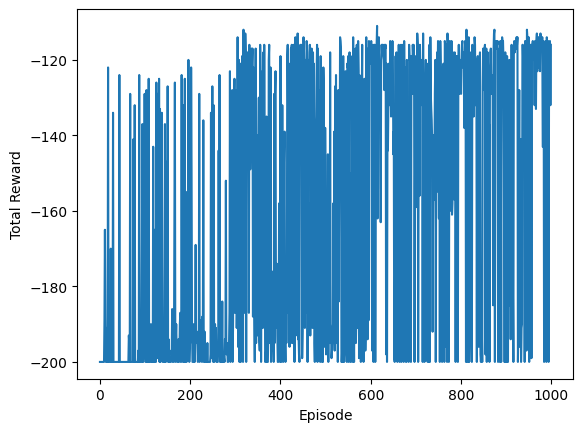

Best episode reward: -111.0


In [6]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import imageio
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")


# 환경 생성
env = gym.make("MountainCar-v0", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# 상태 정규화를 위한 스케일러 준비
state_samples = np.array([env.observation_space.sample() for _ in range(10000)])
scaler = StandardScaler()
scaler.fit(state_samples)

# Actor-Critic 모델 생성
def build_actor_critic_model(state_size, action_size):
    # 공유 레이어
    input_layer = keras.layers.Input(shape=(state_size,))
    dense1 = keras.layers.Dense(64, activation='tanh')(input_layer)
    dense2 = keras.layers.Dense(32, activation='tanh')(dense1)

    # Actor 출력 (정책)
    policy = keras.layers.Dense(action_size, activation='softmax')(dense2)

    # Critic 출력 (가치)
    value = keras.layers.Dense(1)(dense2)

    # 모델 생성
    model = keras.models.Model(inputs=input_layer, outputs=[policy, value])

    return model

# 모델 및 옵티마이저 설정
model = build_actor_critic_model(state_size, action_size)
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

# 하이퍼파라미터
discount_factor = 0.99
episodes = 1000

# 학습 함수
def train_step(state, action, reward, next_state, done):
    with tf.GradientTape() as tape:
        # 현재 상태와 다음 상태의 정책과 가치 구하기
        policy, value = model(state)
        _, next_value = model(next_state)

        reward = tf.cast(reward, tf.float32)
        done = tf.cast(done, tf.float32)

        # 타겟 계산
        target = reward + (1 - done) * discount_factor * next_value[0]

        # Actor 손실 계산
        action_one_hot = tf.one_hot(action, action_size)
        log_prob = tf.math.log(tf.reduce_sum(action_one_hot * policy, axis=1) + 1e-10)
        advantage = target - value[0]
        actor_loss = -log_prob * tf.stop_gradient(advantage)

        # Critic 손실 계산
        critic_loss = tf.square(advantage)

        # 전체 손실
        loss = actor_loss + 0.5 * critic_loss

    # 그래디언트 계산 및 적용
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss


reward_history = []
best_reward = -float('inf')
best_frames = []

# 학습 루프
for episode in range(episodes):
    state = env.reset()[0]
    episode_reward = 0
    done = False
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)
        state_tensor = tf.convert_to_tensor(state.reshape(1, -1), dtype=tf.float32)
        policy, _ = model(state_tensor)
        action = np.random.choice(action_size, p=policy[0].numpy())

        # 환경에 행동 적용
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        # 보상 설계
        position = next_state[0]
        velocity = next_state[1]

        # 보상 설계 (위치와 속도 고려)
        designed_reward = reward
        if velocity > 0:   # 속도가 있고 오른쪽을 가면 보상 추가
            designed_reward = ((position + 1.2) / 1.8) ** 2

        # 목표 도달 시 추가 보상
        if position >= 0.5:
            designed_reward = 10

        episode_reward += reward
        next_state = scaler.transform([next_state])[0]

        # 학습 단계
        next_state_tensor = tf.convert_to_tensor(next_state.reshape(1, -1), dtype=tf.float32)
        train_step(state_tensor, action, designed_reward, next_state_tensor, done)

        state = next_state

    reward_history.append(episode_reward)
    if episode_reward > best_reward:
        best_reward = episode_reward
        best_frames = frames

    # 에피소드 결과 출력
    if episode % 100 == 0:
        print(f"Episode: {episode}, Reward: {episode_reward}")


from common.utils import plot_total_reward
plot_total_reward(reward_history)

env.close()
print(f"Best episode reward: {best_reward}")


Best episode saved as best_mountaincar2.gif


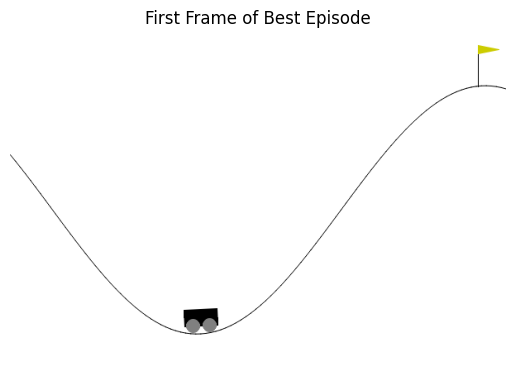

In [7]:
# 이미지로 저장
output_filename = "best_mountaincar2.gif"
imageio.mimsave(output_filename, best_frames, fps=30)
print(f"Best episode saved as {output_filename}")

# 첫 장면만 시각화
plt.imshow(best_frames[0])
plt.title("First Frame of Best Episode")
plt.axis('off')
plt.show()